# Assignment 3
In this assignment, you will be coding two new (nn.Module)s that implement a Linear layer and BatchNorm. Then you will use them to train a conv net over multiple datasets.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import math


import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

Set a global momentum:

In [ ]:
MOMENTUM = 0.9

**Datasets**
In this assignment you will only use training sets. Here, I only load CIFAR10, but you should load the following datasets, which you will use later:


*   CIFAR10
*   Fashion-MNIST
*  KMNIST




In [ ]:
cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# TODO - load more datasets
fmnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
kmnist_trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())



Files already downloaded and verified


# Neural net
This is our vanilla CNN for this experiment. The sizes of the Linear layers were designed for CIFAR10, the first dataset you should experiment with. Later, you will have to change those numbers to fit the other datasets.

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # now a few fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features




In [ ]:
# using 20 epochs due to colab keeps on disconnected - approved by kfir

def train_model(model, EPOCHS=10, BATCH_SIZE=64, trainset=cifar10_trainset, DEVICDE=DEVICE, VERBOSE=False,BASIC_VERBOSE=True):

  if BASIC_VERBOSE:
    print('Training - began...')

  # define loss function
  criterion = nn.CrossEntropyLoss()

  # define the optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  # dataloader
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

  # model to device
  model = model.to(DEVICE)

  # training loop
  Loss = []
  for epoch in range(EPOCHS):  

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs
          inputs, labels = data
          
          inputs = inputs.to(DEVICE) 
          labels = labels.to(DEVICE) 

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          # print statistics
          if VERBOSE:
            if i % 200 == 0:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

      Loss.append(running_loss/len(trainloader))

  if BASIC_VERBOSE:
    print('Training - Done!')
    print('loss len: ', len(Loss), '\tfinal loss: ', Loss[-1])
  return Loss

In [ ]:
# Creating the network 
net = CNN()
print(net)

loss_CNN = train_model(net);

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Training - began...
Training - Done!
loss len:  10 	final loss:  1.4953267613945105


# Task 1
Implement a nn.Module that immitates nn.Linear, with additional support for Dropout. In other words, this module should take three arguments: input dimension, output dimension and the keep_prop probability for dropout. Make sure to wrap your parameter tensors with nn.Parameter.

In [ ]:
# TODO: Implement the following Module. Size is the length of the input vectors.

class MyLinear(nn.Module):
  def __init__(self, input_dim, output_dim, keep_prob=0.):
    super(MyLinear, self).__init__()
    #...
    self.W = torch.nn.Parameter(torch.randn(output_dim,input_dim))
    self.W.requires_grad = True
    # nn.init.kaiming_normal_(self.W, mode='fan_out')

    self.bias = torch.nn.Parameter(torch.randn(output_dim))
    self.bias.requires_grad = True

    self.keep_prob = keep_prob

    # initialize weights and biases
    nn.init.kaiming_uniform_(self.W)
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W)
    bound = 1 / math.sqrt(fan_in)
    nn.init.uniform_(self.bias, -bound, bound)
    
  def forward(self, x):
    # ...
    output = x @ self.W.t() + self.bias
    if self.training:
      sample = torch.distributions.bernoulli.Bernoulli(self.keep_prob).sample(output.size()).to(output.device)
      return output * sample
    return output


# testing
ml = MyLinear(5,2,keep_prob=1).to(DEVICE)
ml.forward(torch.rand(5).to(DEVICE))

tensor([ 2.1167, -0.6263], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
class MyCNN(nn.Module):

    def __init__(self,keep_prob=1):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # now a few fully connected layers
        self.fc1 = MyLinear(16 * 5 * 5, 120, keep_prob)
        self.fc2 = MyLinear(120, 84, keep_prob)
        self.fc3 = MyLinear(84, 10, keep_prob)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Task 2
You should add your new MyLinear Module to our CNN. Simply replace fc1, fc2, and fc3 with your new module, this time with keep_prob=1. Then, train the network over CIFAR10 with and without your Module, and compare the loss curves (plot both of them onto the same figure, with two different colors).



In [ ]:
# You code for Task 2 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

mynet = MyCNN()
loss_MyCNN = train_model(mynet)

Training - began...
Training - Done!
loss len:  10 	final loss:  1.3087838785270292


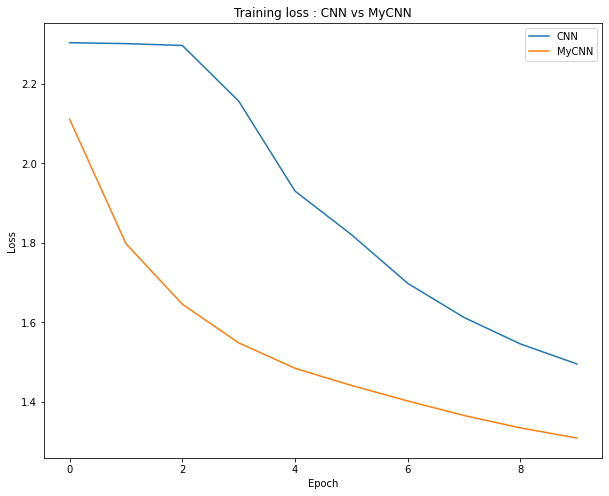

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(loss_CNN, label='CNN')
plt.plot(loss_MyCNN, label='MyCNN')

plt.title('Training loss : CNN vs MyCNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Task 3

Use your MyLinear module like before, but this time compare the loss curves of two runs: keep_prob = 1 and keep_prob = 0.5.

In [ ]:
# You code for Task 3 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

# Creating the network 
mynet_DO = MyCNN(keep_prob=0.5)
loss_MyCNN_DO05 = train_model(mynet_DO)

Training - began...
Training - Done!
loss len:  10 	final loss:  2.204650914882455


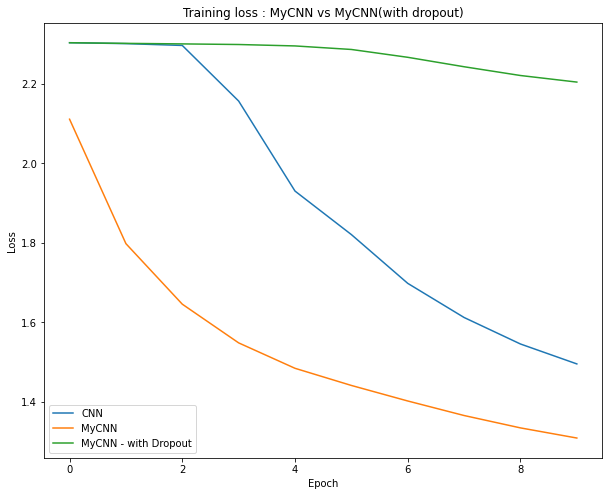

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(loss_CNN, label='CNN')
plt.plot(loss_MyCNN, label='MyCNN')
plt.plot(loss_MyCNN_DO05, label='MyCNN - with Dropout')

plt.title('Training loss : MyCNN vs MyCNN(with dropout)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that the network with the dropout converges much slower.  
This makes sense since using dropout causes the network to generelize and avoid overfitting on the training set, resulting in a slower convergence on the training set. If we would look at the loss on the testset we should see a nice converges.

<br><br><br>
<br><br><br>

# Task 4

Implement a Module that performs Batch Normalization for the output of a Linear Module. In a nutshel, in it's forward procedure, this module should standartize the input (assumed to be of the same shape you use with nn.Linear, that is, (N, L) = N is the number of vectors in the batch, and L is the input vector), and then multiply it by gamma and add beta. Gamma and beta should be learnable, i.e., of nn.Parameter type.
Use running average to calculate the relevant information for testing time, and store them accordingly.

In [ ]:
# TODO: Implement the following Module. Size is the length of the input vectors.

class MyBatchNorm(nn.Module):
    def __init__(self, size, epsilon=1e-05):
        super(MyBatchNorm, self).__init__()
        #...
        # initialize layer parameters 
        self.size = size
        self.gamma = nn.Parameter(torch.ones(self.size))
        self.beta = nn.Parameter(torch.zeros(self.size))
        self.epsilon = epsilon
        
        # with momentum
        # sel.momentum = momentum
        
        self.moving_mean = torch.zeros(self.size)
        self.moving_var = torch.zeros(self.size)
        self.n_batches = torch.zeros(self.size)
        
        
    def forward(self, x):
        # ...
        
        self.moving_mean = self.moving_mean.to(x.device)
        self.moving_var = self.moving_var.to(x.device)
        self.n_batches = self.n_batches.to(x.device)
        
        if not torch.is_grad_enabled():
            out = (x - self.moving_mean) / (self.moving_var + self.epsilon).sqrt()
            
        else:
        
            mu = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False) 

            numerator = x - mu
            denominator = (var + self.epsilon).sqrt()

            normalized_input = numerator / denominator
            out = self.gamma*normalized_input + self.beta
            
            # update running mean and running var - with momentum=0.9
            self.moving_mean = 0.9 * self.moving_mean + 0.1 * mu
            self.moving_var = 0.9 * self.moving_var + 0.1 * var

            # update running mean and running var - with momentum as var
            # self.moving_mean = self.momentum * self.moving_mean + (1.0 - self.momentum) * mu
            # self.moving_var = self.momentum * self.moving_var + (1.0 - self.momentum) * var
            
        return out

Please notice there is not `momentum` in your class definition.  
So we used a static approach with `momentum=0.9` . but we added in notes what we have done if we could use `momentum` as var.


<br><br><br>

In [ ]:
class MyCNN(nn.Module):

    def __init__(self,keep_prob=1,BN=True,conv1_dim=3,fc1_dim=5):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(conv1_dim, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # now a few fully connected layers
        self.fc1 = MyLinear(16 * fc1_dim * fc1_dim, 120, keep_prob)
        self.fc2 = MyLinear(120, 84, keep_prob)
        self.fc3 = MyLinear(84, 10, keep_prob)

        self.BN = BN

        if self.BN:
          self.bn1 = MyBatchNorm(120)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        
        if self.BN:
          x = self.bn1(x)
  
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Task 5
You should add your new MyBatchNorm Module to our CNN, right after fc1. Then, train the network over CIFAR10 with and without your Module, and compare the loss curves (plot both of them onto the same figure, with two different colors).

In [ ]:
# Creating the network 
mynet_BN = MyCNN()
loss_MyCNN_BN = train_model(mynet_BN)

Training - began...
Training - Done!
loss len:  10 	final loss:  1.246200812975769


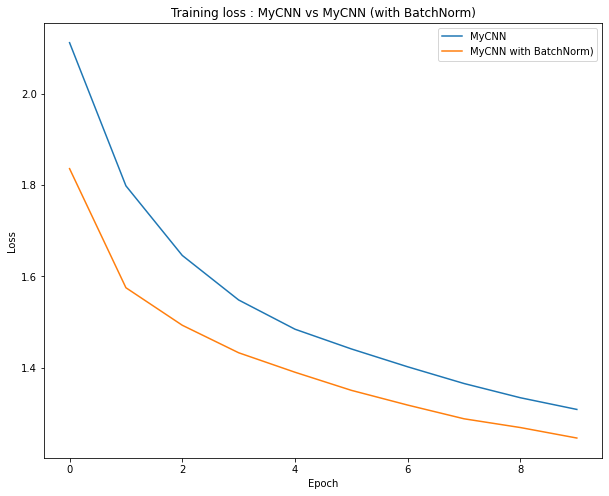

In [ ]:
# You code for Task 5 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.
plt.figure(figsize=(10,8))
plt.plot(loss_MyCNN, label='MyCNN')
plt.plot(loss_MyCNN_BN, label='MyCNN with BatchNorm)')

plt.title('Training loss : MyCNN vs MyCNN (with BatchNorm)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Task 6
Run your network over all training sets, with and without batch norm, as designed in Task 4 and 5.
Present 6 curves, two for each dataset.

In [ ]:
# You code for Task 6 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.
ts = {
    'cifar10' : cifar10_trainset,
    'fmnist' : fmnist_trainset,
    'kmnist' : kmnist_trainset
      }

bn = {
    'Without BatchNorm': False,
    'With BatchNorm': True
      }

losses = {}
for trainset_k,trainset_v in ts.items():
  for batchnorm_k,batchnorm_v in bn.items():
    print('Training: ', trainset_k + ' - ' + batchnorm_k,end='\t')

    if trainset_k == 'cifar10':
      model = MyCNN(BN=batchnorm_v,conv1_dim=3,fc1_dim=5)
    else:
      model = MyCNN(BN=batchnorm_v,conv1_dim=1,fc1_dim=4)
    
    model_loss = train_model(model,trainset=trainset_v, BASIC_VERBOSE=False)
    losses[trainset_k + ' - ' + batchnorm_k] = model_loss
    print('loss: ',model_loss,'\n')

Training:  cifar10 - Without BatchNorm	loss:  [2.1216699051125274, 1.8326148582846307, 1.6759491360096066, 1.5776992688703415, 1.520840478217815, 1.4675254105302074, 1.425938338879734, 1.3821698591837188, 1.3581940076692636, 1.326023618964588] 

Training:  cifar10 - With BatchNorm	loss:  [1.9447640340651393, 1.6020184858985569, 1.479702270091952, 1.4193650395668986, 1.3756681208110526, 1.3427663419557654, 1.3151938236125595, 1.2915271178383352, 1.2777155813048868, 1.255501647129693] 

Training:  fmnist - Without BatchNorm	loss:  [0.9857691485109106, 0.5872844121158759, 0.5155490858754369, 0.4729409536350765, 0.4391588492593023, 0.41949584428816716, 0.4026492762127156, 0.3841795265309211, 0.3730188133492907, 0.36245113739898716] 

Training:  fmnist - With BatchNorm	loss:  [0.6741295480079996, 0.44353619321132265, 0.39061043371778054, 0.3602653448579154, 0.3400840998045417, 0.323260446617217, 0.3115955612409725, 0.30034793189752584, 0.2934216688325537, 0.28592690234499446] 

Training:  k

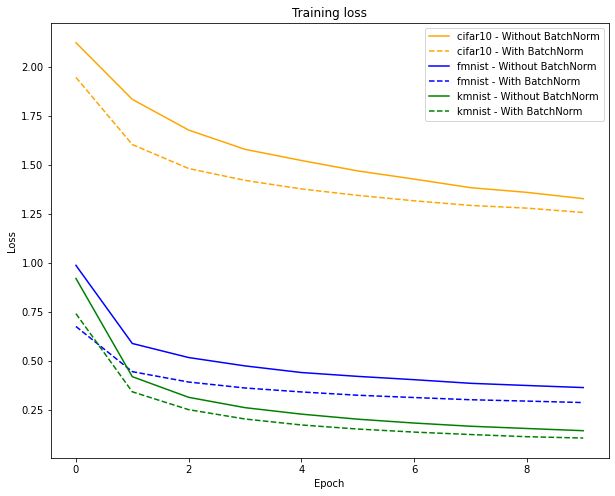

In [ ]:
# plot
line_style = ['solid','dashed','solid','dashed','solid','dashed'] 
line_color = ['orange','orange','blue','blue','green','green']

plt.figure(figsize=(10,8))

for (k,v),ls,lc in zip(losses.items(),line_style,line_color):
  plt.plot(v, label=k,linestyle=ls,color=lc)

plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Conclusions:

As we can see, in all the different datasets, the training with the batch normalization converges faster.  
This makes sense, since the step towards the global minimum using batch normalization is more efficient - instead of preferring going towards the gradient which might have a higher magnitude in some dimension due to the dimension's high absolute values, normalizaing the different dimensions and then going towards the negative direction of the gradient will be a more accurate direction to the global minimum  